(57, 105, 172)


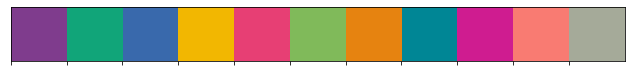

In [1]:
import os
import sys
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import plotly.io as pio
import plotly.express as px
import webcolors as wc
pio.templates.default = "plotly_white"


def transform_color_palette(colors):
    hex_colors = []
    
    for rgb_str in colors:
        rgb_tuple = tuple([int(x) for x in rgb_str.strip('rgb()').split(',')])
        hex_colors.append(wc.rgb_to_hex(rgb_tuple))

    return hex_colors


bold_colors = px.colors.qualitative.Bold

hex_bold = transform_color_palette(bold_colors)

my_bold_palette = sns.color_palette(hex_bold)
sns.set_palette(my_bold_palette)
sns.palplot(my_bold_palette)

print(bold_colors[2].strip('rgb'))

In [86]:
parent_dir = os.path.dirname(os.getcwd())


def get_coeffs(result_file):
    

    to_read = glob(os.path.join(parent_dir, 'Results', result_file, '*_coeffs.csv'))[0]
    coeffs = pd.read_csv(to_read, index_col=0)
    coeffs.index.name = 'Coefficient'
    coeffs.drop(['cv'], inplace=True)
    coeffs = coeffs.astype(float)
    coeffs.drop(columns=['H4'], inplace=True)
#     print(coeffs)
#     return

    coeffs['mean'] = coeffs.mean(axis=1)
    coeffs['med'] = coeffs.median(axis=1)
    coeffs['min'] = coeffs.min(axis=1)#.abs()
    coeffs['max'] = coeffs.max(axis=1)#.abs()
    coeffs['lbMed'] = coeffs['med']-coeffs['min']
    coeffs['ubMed'] = coeffs['max']-coeffs['med']
    coeffs['lbMean'] = coeffs['mean']-coeffs['min']
    coeffs['ubMean'] = coeffs['max']-coeffs['mean']
    
    coeffs['stdev'] = coeffs.std(axis=1, ddof=1)
    coeffs['errors'] = coeffs['mean'] - 1.96*coeffs['stdev']/np.sqrt(6)
#     coeffs['min_max'] = 

    lag_list = sorted([f'lag{i}_occupied' for i in range(1,9)])
    var_list = ['C', 'Intercept', 'audio', 'img', 'temp', 'rh', 'light', 'co2eq', 'weekend', 'hr_cos', 'hr_sin'] + lag_list
    coeffs['Variables'] = pd.Categorical(coeffs.index, categories=var_list, ordered=True)
    coeffs.sort_values('Variables', inplace=True)
    
    return coeffs

result_file = 'full_noCV_zeroFill'
coef_df = get_coeffs(result_file)
print(coef_df)

result_file_cv = 'full_CV_zeroFill'
coef_df_cv = get_coeffs(result_file_cv)

                 H1    H2    H3    H5    H6   mean    med   min   max  lbMed  \
Coefficient                                                                    
C              0.10  0.10  0.10  0.10  0.10  0.100  0.100  0.10  0.10  0.000   
Intercept     -7.46 -3.74 -4.13 -3.11 -3.83 -4.454 -3.980 -7.46 -3.11  3.480   
audio          0.48  3.18  5.21  2.20  5.67  3.348  3.264  0.48  5.67  2.784   
img            0.00  2.93  0.00  0.00  0.00  0.586  0.000  0.00  2.93  0.000   
temp           6.09  0.00  0.00  0.00 -0.21  1.176  0.000 -0.21  6.09  0.210   
rh             0.00  0.00  0.00  0.00  0.00  0.000  0.000  0.00  0.00  0.000   
light          0.00  0.00  0.00  0.00  0.00  0.000  0.000  0.00  0.00  0.000   
co2eq          0.00  0.00  0.00  0.00  0.00  0.000  0.000  0.00  0.00  0.000   
weekend        0.69  0.17  0.00  0.00  0.00  0.172  0.085  0.00  0.69  0.085   
hr_cos         1.10  0.60  1.57  0.49  1.13  0.978  1.039  0.49  1.57  0.549   
hr_sin         0.19  1.22 -0.32  0.14  0

In [101]:
def plot_coeffs(coef_df, fname='', plot_2=False, fs=22):
#     print(coef_df)

#     coeff_vars = coef_df['variables']
#     coef_df.drop(['Intercept', 'audio', 'lag1_occupied', 'lag2_occupied'], inplace=True)
#     large_cols = ['Intercept', 'audio', 'lag1_occupied', 'lag2_occupied']

#     for c in large_cols:
#         coef_df.loc[c,:] = np.nan
#     coef_df['variables'] = coeff_vars
        
#     print(coef_df)
# #         coef_df[c].loc[coef_df[c].isnull().any(axis=1), :] = np.nan
    sns.set_context('notebook')



    fig, ax = plt.subplots(figsize=(13,10))
    coef_df.plot(x='Variables', y='mean', kind='bar',
                 ax=ax, color='none', fontsize=fs, 
                 ecolor=hex_bold[2],capsize=8,
#                  yerr = coef_df[['lbMed', 'ubMed']].values.T, legend=False)
                 yerr = coef_df[['lbMean', 'ubMean']].values.T, legend=False)

                 
    ax.scatter(x=np.arange(coef_df.shape[0]), 
           marker='o', s=80, 
           y=coef_df['mean'], color=hex_bold[2], label='No CV')
    
    
    # Set title & labels
#     plt.title('Coefficients of Features',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=fs)
    ax.set_xlabel('Variables',fontsize=22)
    
    if plot_2:
        
        coef_df.plot(x='Variables', y='mean_cv', kind='bar', width=0.6, align='edge',
                     ax=ax, color='none', fontsize=fs,
                     ecolor=hex_bold[6],capsize=8,
                     yerr=coef_df[['lbMean_cv', 'ubMean_cv']].values.T, legend=False)

        ax.scatter(x=np.arange(coef_df.shape[0])+0.3, 
               marker='o', s=80,
               y=coef_df['mean_cv'], color=hex_bold[6], label='Cross-validated')


        ax.legend(['No CV (C=0.1)', 'Cross-validated C'], fontsize='xx-large')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
#     plt.ylim([-12, 18])
    
    save_loc = os.path.join(parent_dir, 'Results', 'Plots', f'{fname}_coeffs.pdf')
    
    plt.tight_layout()
    plt.savefig(save_loc)
    return plt

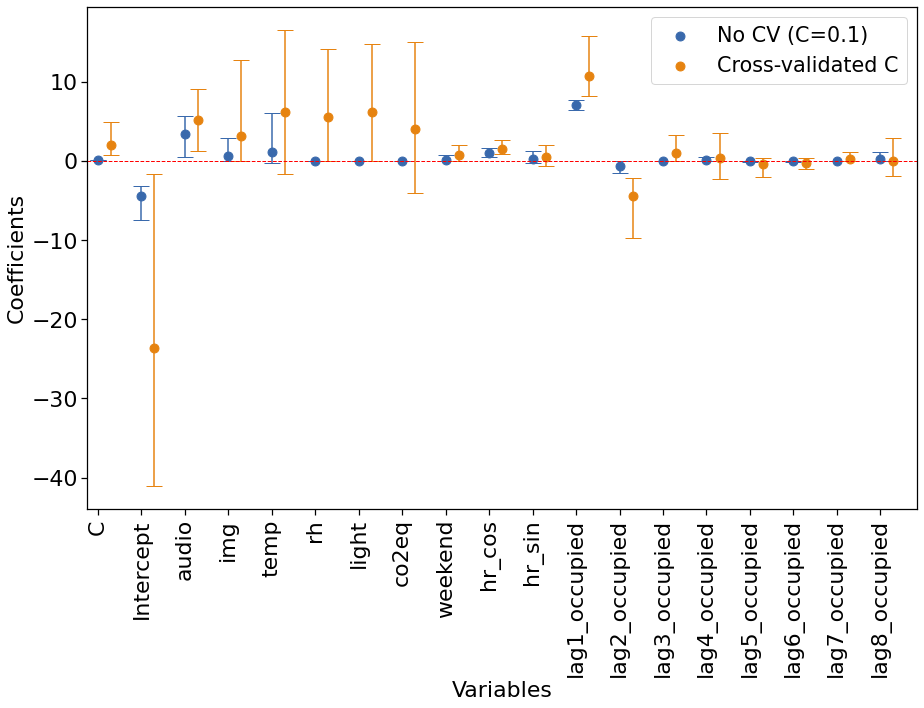

In [102]:
col_vars = ['mean', 'errors', 'med', 'min', 'max', 'lbMean', 'ubMean', 'lbMed', 'ubMed']
df = coef_df[col_vars + ['Variables']].join(coef_df_cv[col_vars], rsuffix='_cv')
# print(df)

multi_coef_plot = plot_coeffs(coef_df=df, fname='multi', plot_2=True)
multi_coef_plot.show()

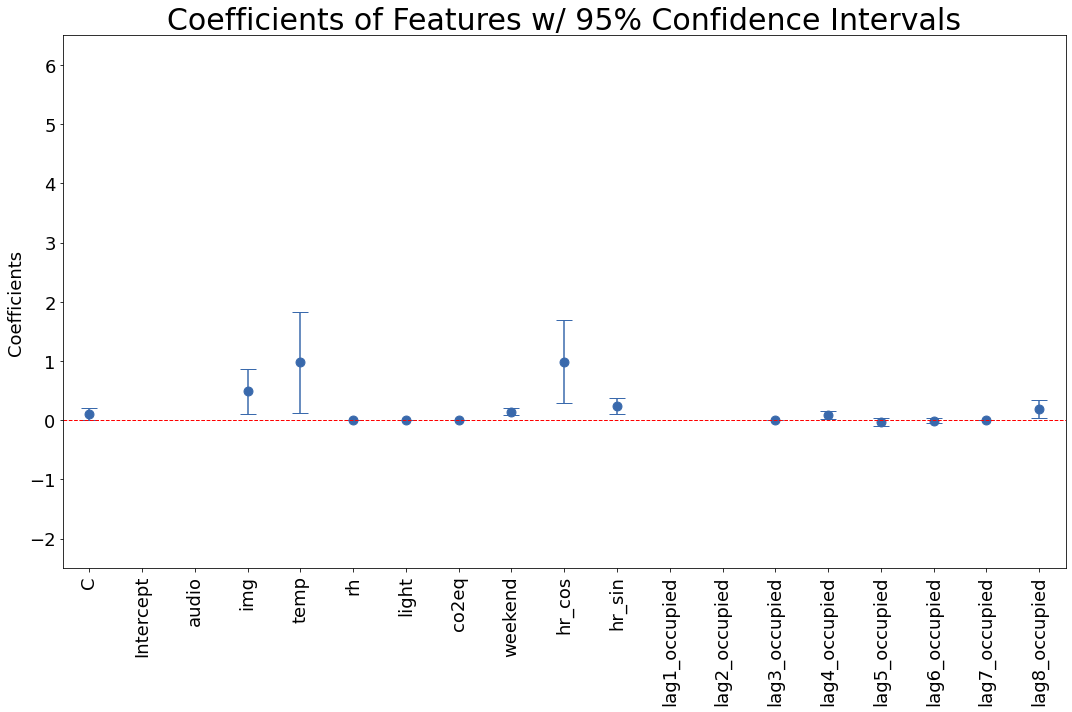

In [9]:
result_file = 'full_noCV_zeroFill'
coef_df = get_coeffs(result_file)

coef_plot = plot_coeffs(coef_df=coef_df, fname='no_CV')
coef_plot.show()

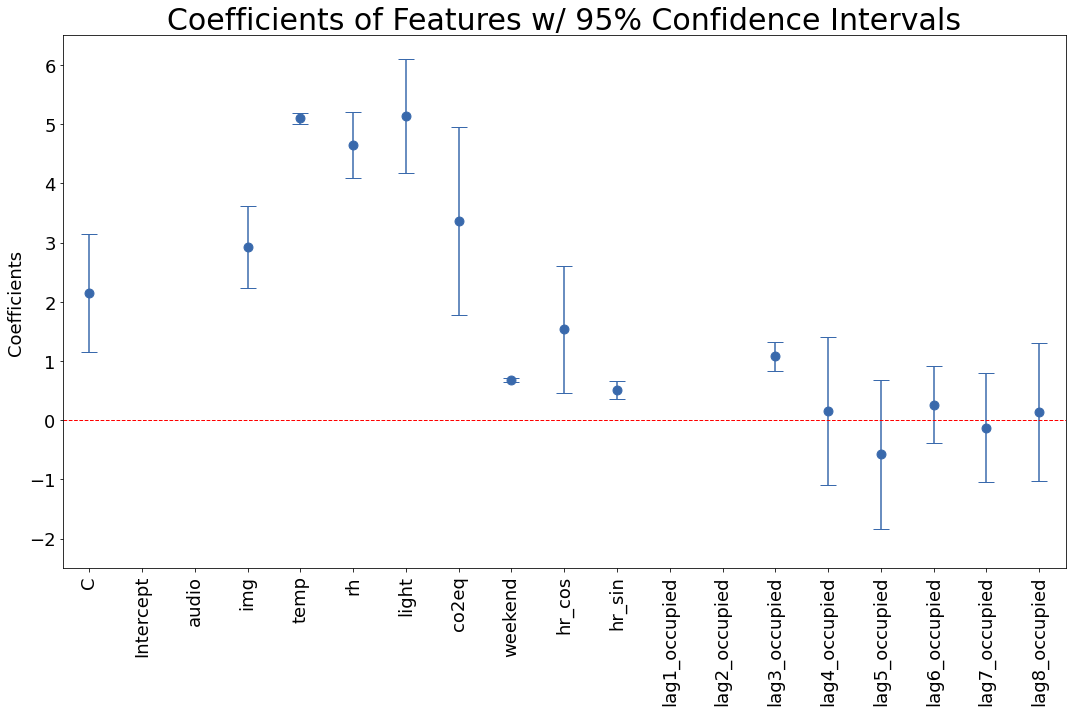

In [7]:
result_file_cv = 'full_CV_zeroFill'
coef_df_cv = get_coeffs(result_file_cv)
coef_cv = plot_coeffs(coef_df=coef_df_cv, fname='CV')
coef_cv.show()